In [2]:
import tensorflow as tf

!nvidia-smi  
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tue Feb 18 10:47:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 30.7 MB/s eta 0:00:00


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import visualkeras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pydot
import graphviz
from matplotlib.image import imread
import cv2
import os

In [22]:
labels = pd.read_csv("/kaggle/input/inbreast/Training_set.csv")
labels.head()

,filename,label
0,Image_1.jpg,Density3Benign
1,Image_2.jpg,Density1Benign
2,Image_3.jpg,Density1Malignant
3,Image_4.jpg,Density1Benign
4,Image_5.jpg,Density1Malignant


In [23]:
file_paths = [[fname, 'train/' + fname] for fname in labels['filename']]

In [24]:
if len(labels) == len(file_paths):
    print('Number of labels i.e. ', len(labels), 'matches the number of filenames i.e. ', len(file_paths))
else:
    print('Number of labels does not match the number of filenames')

Number of labels i.e.  5724 matches the number of filenames i.e.  5724


In [25]:
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
images.head()

,filename,filepaths
0,Image_1.jpg,train/Image_1.jpg
1,Image_2.jpg,train/Image_2.jpg
2,Image_3.jpg,train/Image_3.jpg
3,Image_4.jpg,train/Image_4.jpg
4,Image_5.jpg,train/Image_5.jpg


In [21]:
train_data = pd.merge(images, labels, how = 'inner', on = 'filename')
train_data.head()

,filename,filepaths,label
0,Image_1.jpg,train/Image_1.jpg,Density3Benign
1,Image_2.jpg,train/Image_2.jpg,Density1Benign
2,Image_3.jpg,train/Image_3.jpg,Density1Malignant
3,Image_4.jpg,train/Image_4.jpg,Density1Benign
4,Image_5.jpg,train/Image_5.jpg,Density1Malignant


# EDA

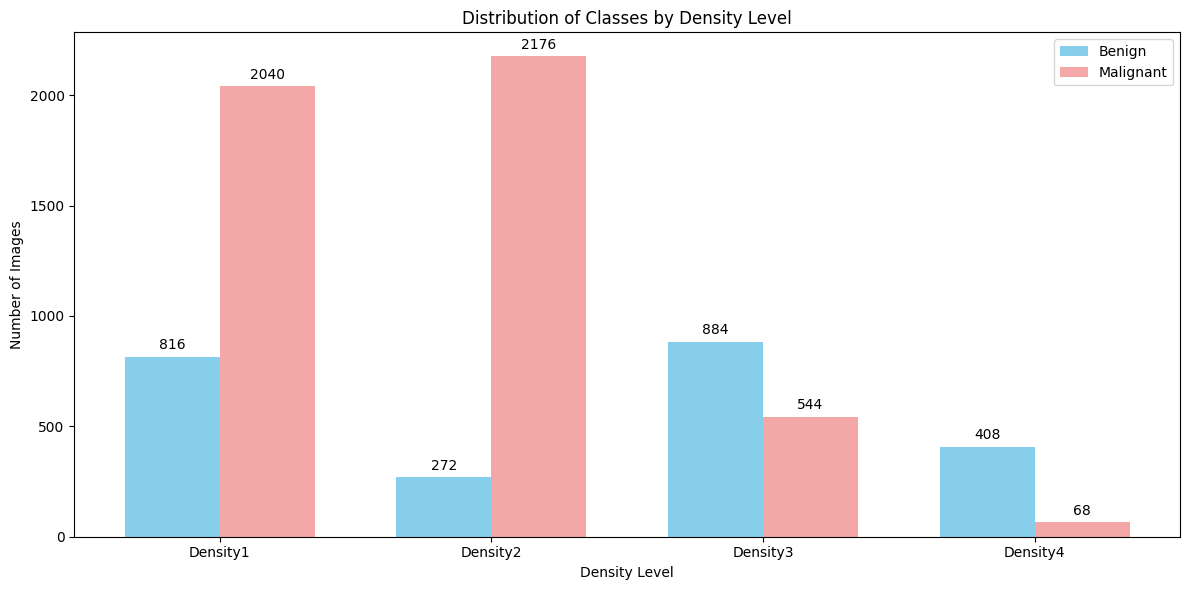

In [19]:
import matplotlib.pyplot as plt
import numpy as np

categories = ['Density1', 'Density2', 'Density3', 'Density4']
benign = [816, 272, 884, 408]
malignant = [2040, 2176, 544, 68]

x = np.arange(len(categories))
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x - width/2, benign, width, label='Benign', color='#87CEEB')  # Light blue
rects2 = ax.bar(x + width/2, malignant, width, label='Malignant', color='#F4A7A7')  # Light red

ax.set_ylabel('Number of Images')
ax.set_xlabel('Density Level')
ax.set_title('Distribution of Classes by Density Level')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Add value labels on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Adjust layout
plt.tight_layout()

plt.show()

In [26]:
base_path = '/kaggle/input/inbreast'
train_data['filepaths'] = train_data['filepaths'].apply(lambda x: os.path.join(base_path, 'mamog', 'train', os.path.basename(x)))

print("New path:", train_data['filepaths'][0])
print("File exists:", os.path.exists(train_data['filepaths'][0]))

New path: /kaggle/input/inbreast/mamog/train/Image_1.jpg
File exists: True


In [27]:
first_image = train_data['filepaths'][0]

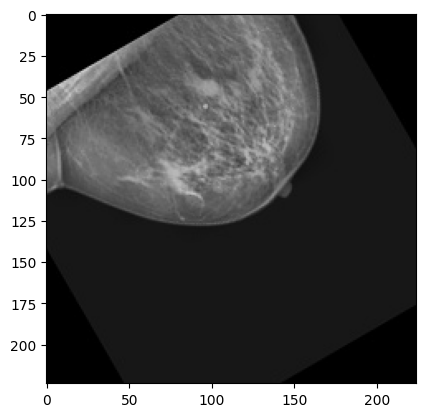

In [28]:
plt.imshow(imread(first_image))

In [29]:
dim1 = []
dim2 = []

for i in range(len(train_data)):
    img = imread(train_data['filepaths'][i])
    d1,d2,color = img.shape
    dim1.append(d1)
    dim2.append(d2)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


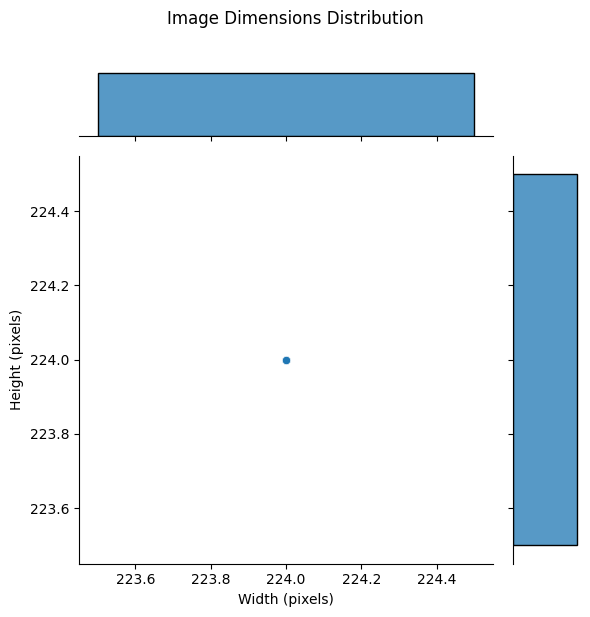

In [30]:

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({
    'Height': dim1,
    'Width': dim2
})

g = sns.jointplot(
    data=df,
    x='Width',
    y='Height',
    kind='scatter'
)

# Add labels and title
g.fig.suptitle('Image Dimensions Distribution', y=1.02)
g.ax_joint.set_xlabel('Width (pixels)')
g.ax_joint.set_ylabel('Height (pixels)')

plt.tight_layout()
plt.show()

In [31]:
data = []
image_size = 224
for i in range(len(train_data)):

    img_array = cv2.imread(train_data['filepaths'][i], cv2.IMREAD_GRAYSCALE)
    new_img_array = cv2.resize(img_array, (image_size, image_size))
    if train_data['label'][i] == 'Density1Benign':
        data.append([new_img_array, 0])
    elif train_data['label'][i] == 'Density1Malignant':
        data.append([new_img_array, 1])
    elif train_data['label'][i] == 'Density2Benign':
        data.append([new_img_array, 2])
    elif train_data['label'][i] == 'Density2Malignant':
        data.append([new_img_array, 3])
    elif train_data['label'][i] == 'Density3Benign':
        data.append([new_img_array, 4])
    elif train_data['label'][i] == 'Density3Malignant':
        data.append([new_img_array, 5])
    elif train_data['label'][i] == 'Density4Benign':
        data.append([new_img_array, 6])
    elif train_data['label'][i] == 'Density4Malignant':
        data.append([new_img_array, 7])

In [32]:
data[0]

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 4]

In [33]:
np.random.shuffle(data)

In [34]:
x = []
y = []
for image in data:
    x.append(image[0])
    y.append(image[1])

x = np.array(x)
y = np.array(y)

In [35]:
x = x.reshape(x.shape[0], 224, 224, 1)

In [36]:
x.shape

(5724, 224, 224, 1)

In [37]:
image_shape = (224, 224, 1)

In [38]:
X_train, X_val, y_train, y_val = train_test_split(x,y,test_size=0.20, random_state = 42)

In [41]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), input_shape=image_shape, padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))  
model.add(Dropout(0.3))  


model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))  
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))  
model.add(Dropout(0.3))  

model.add(Flatten())
model.add(Dense(128, activation='relu')) 
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(8, activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=5e-4),  
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [42]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 224, 224, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 401408)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      51,380,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,483,336 (196.39 MB)

 Trainable params: 51,482,568 (196.39 MB)

 Non-trainable params: 768 (3.00 KB)

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


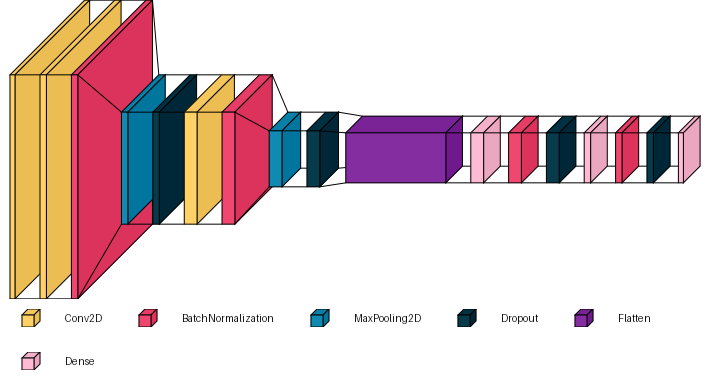

In [43]:
import visualkeras
from tensorflow.keras.utils import plot_model

# First, let's create a text-based visualization
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Then create a more detailed layered visualization using visualkeras
visualkeras.layered_view(model,
                        to_file='model_layered_view.png',
                        legend=True,
                        draw_volume=True,
                        spacing=25,
                        scale_z=0.1,    
                        scale_xy=1,
                        min_z=5,       
                        min_xy=50,
                        max_z=100,      
                        color_map={
                            'Conv2D': '#FFA07A', 
                            'MaxPooling2D': '#98FB98', 
                            'BatchNormalization': '#87CEFA', 
                            'Dropout': '#DDA0DD',  
                            'Dense': '#F0E68C',  
                            'Flatten': '#FFB6C1'  
                        })

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), input_shape=image_shape, padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))  
model.add(Dropout(0.3))  


model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))  
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))  
model.add(Dropout(0.3))  

model.add(Flatten())
model.add(Dense(128, activation='relu')) 
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(8, activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=5e-4),  
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [44]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Рассчитываем веса классов
unique_classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train
)

# Создаем словарь весов
class_weight_dict = dict(zip(unique_classes, class_weights))

print("Class weights:", class_weight_dict)

Class weights: {0: 1.1245088408644401, 1: 0.4346051632498102, 2: 3.4900914634146343, 3: 0.41901537335285505, 4: 1.0059314586994728, 5: 1.654263005780347, 6: 2.1599056603773583, 7: 13.311046511627907}


In [45]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,  # уменьшим batch size
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
    ]
)

Epoch 1/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 35s 148ms/step - accuracy: 0.1388 - loss: 2.7100 - val_accuracy: 0.1345 - val_loss: 2.2470 - learning_rate: 5.0000e-04
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.1540 - loss: 2.3017 - val_accuracy: 0.0664 - val_loss: 2.3995 - learning_rate: 5.0000e-04
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.1760 - loss: 1.9751 - val_accuracy: 0.0550 - val_loss: 2.8882 - learning_rate: 5.0000e-04
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.2047 - loss: 1.7646 - val_accuracy: 0.1825 - val_loss: 2.0350 - learning_rate: 5.0000e-04
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.2570 - loss: 1.6020 - val_accuracy: 0.1878 - val_loss: 2.0903 - learning_rate: 5.0000e-04
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.3172 - loss: 1.3823 - val_accuracy: 0.2611 - val_loss: 1.8454 - learning_rate: 5.0000e-04
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 

In [56]:
from sklearn.model_selection import KFold
import numpy as np
from tensorflow.keras.models import clone_model

def create_model(input_shape):
    model = Sequential([
        Conv2D(32, kernel_size=(3,3), input_shape=input_shape, padding='same', activation='relu'),
        Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=2),
        Dropout(0.3),
        
        Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=2),
        Dropout(0.3),
        
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(8, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=5e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Настройка кросс-валидации
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Списки для хранения метрик
val_accuracies = []
val_losses = []

# Кросс-валидация
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f'\nFold {fold + 1}/{n_splits}')
    
    # Разделение данных
    X_train_fold = X_train[train_idx]
    y_train_fold = y_train[train_idx]
    X_val_fold = X_train[val_idx]
    y_val_fold = y_train[val_idx]
    
    # Создание новой модели для каждого фолда
    model = create_model(image_shape)
    
    # Расчет весов классов для текущего фолда
    unique_classes = np.unique(y_train_fold)
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=unique_classes,
        y=y_train_fold
    )
    class_weight_dict = dict(zip(unique_classes, class_weights))
    
    # Обучение модели
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_fold, y_val_fold),
        class_weight=class_weight_dict,
        callbacks=[
            EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            ),
            ReduceLROnPlateau(
                factor=0.5,
                patience=5,
                min_lr=1e-6
            )
        ],
        verbose=1
    )
    
    # Оценка модели на валидационном наборе
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)
    
    print(f'Fold {fold + 1} - Val Accuracy: {val_accuracy:.4f}, Val Loss: {val_loss:.4f}')

# Вывод средних результатов
print('\nCross-validation results:')
print(f'Mean validation accuracy: {np.mean(val_accuracies):.4f} ± {np.std(val_accuracies):.4f}')
print(f'Mean validation loss: {np.mean(val_losses):.4f} ± {np.std(val_losses):.4f}')


Fold 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 25s 166ms/step - accuracy: 0.1351 - loss: 2.9680 - val_accuracy: 0.1048 - val_loss: 2.4106 - learning_rate: 5.0000e-04
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.1436 - loss: 2.5080 - val_accuracy: 0.1212 - val_loss: 2.1452 - learning_rate: 5.0000e-04
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.1837 - loss: 2.2570 - val_accuracy: 0.1627 - val_loss: 2.0170 - learning_rate: 5.0000e-04
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.1807 - loss: 1.9983 - val_accuracy: 0.1790 - val_loss: 2.1538 - learning_rate: 5.0000e-04
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.2195 - loss: 1.8914 - val_accuracy: 0.2074 - val_loss: 1.9452 - learning_rate: 5.0000e-04
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.2710 - loss: 1.5860 - val_accuracy: 0.2358 - val_loss: 1.8934 - learning_rate: 5.0000e-04
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/s

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.1331 - loss: 2.8900 - val_accuracy: 0.1376 - val_loss: 2.3974 - learning_rate: 5.0000e-04
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.1430 - loss: 2.5371 - val_accuracy: 0.1103 - val_loss: 3.6567 - learning_rate: 5.0000e-04
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.1398 - loss: 2.4064 - val_accuracy: 0.1485 - val_loss: 2.3120 - learning_rate: 5.0000e-04
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.1518 - loss: 2.1675 - val_accuracy: 0.1419 - val_loss: 2.2171 - learning_rate: 5.0000e-04
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.1663 - loss: 2.0789 - val_accuracy: 0.1452 - val_loss: 2.1297 - learning_rate: 5.0000e-04
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.1773 - loss: 1.9502 - val_accuracy: 0.1419 - val_loss: 2.1136 - learning_rate: 5.0000e-04
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/s

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.1251 - loss: 2.9288 - val_accuracy: 0.1223 - val_loss: 2.3561 - learning_rate: 5.0000e-04
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.1527 - loss: 2.4043 - val_accuracy: 0.1114 - val_loss: 2.2960 - learning_rate: 5.0000e-04
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.1689 - loss: 2.2532 - val_accuracy: 0.2085 - val_loss: 2.1020 - learning_rate: 5.0000e-04
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.2117 - loss: 1.8533 - val_accuracy: 0.1517 - val_loss: 2.0853 - learning_rate: 5.0000e-04
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.2822 - loss: 1.5978 - val_accuracy: 0.1419 - val_loss: 2.1220 - learning_rate: 5.0000e-04
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.3449 - loss: 1.3452 - val_accuracy: 0.2238 - val_loss: 2.0101 - learning_rate: 5.0000e-04
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/s

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 115ms/step - accuracy: 0.1176 - loss: 3.0288 - val_accuracy: 0.1299 - val_loss: 2.2682 - learning_rate: 5.0000e-04
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.1368 - loss: 2.5260 - val_accuracy: 0.1528 - val_loss: 2.2411 - learning_rate: 5.0000e-04
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.1847 - loss: 2.0652 - val_accuracy: 0.1517 - val_loss: 2.0818 - learning_rate: 5.0000e-04
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.2381 - loss: 1.7980 - val_accuracy: 0.1790 - val_loss: 1.9701 - learning_rate: 5.0000e-04
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.3172 - loss: 1.4630 - val_accuracy: 0.1943 - val_loss: 1.9565 - learning_rate: 5.0000e-04
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.3106 - loss: 1.4020 - val_accuracy: 0.1528 - val_loss: 3.5788 - learning_rate: 5.0000e-04
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/s

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 26s 176ms/step - accuracy: 0.1260 - loss: 2.7039 - val_accuracy: 0.1388 - val_loss: 2.6723 - learning_rate: 5.0000e-04
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.1699 - loss: 2.2566 - val_accuracy: 0.1399 - val_loss: 2.4030 - learning_rate: 5.0000e-04
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.1853 - loss: 2.0868 - val_accuracy: 0.1792 - val_loss: 2.1014 - learning_rate: 5.0000e-04
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.2143 - loss: 1.8627 - val_accuracy: 0.1869 - val_loss: 1.9600 - learning_rate: 5.0000e-04
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.2814 - loss: 1.5174 - val_accuracy: 0.2284 - val_loss: 1.9354 - learning_rate: 5.0000e-04
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.3655 - loss: 1.2461 - val_accuracy: 0.2689 - val_loss: 1.9647 - learning_rate: 5.0000e-04
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/s

In [46]:
# early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

In [47]:
# model.fit(X_train, y_train, epochs = 100, batch_size = 64, validation_data = (X_val, y_val), callbacks = [early_stop])

In [57]:
metrics = pd.DataFrame(model.history.history)

In [58]:
metrics[['loss', 'val_loss']].plot()

KeyError: "None of [Index(['loss', 'val_loss'], dtype='object')] are in the [columns]"

<Axes: >

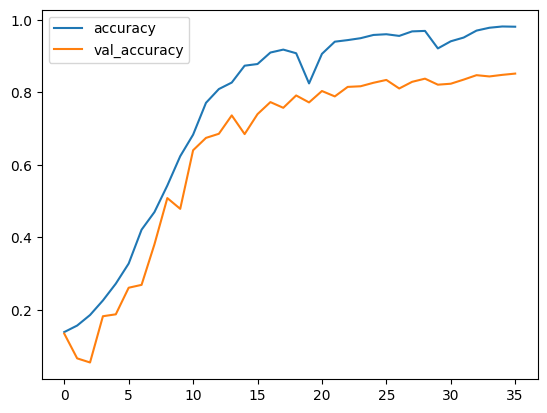

In [50]:
metrics[['accuracy', 'val_accuracy']].plot()

In [59]:
model.evaluate(X_val, y_val)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7617 - loss: 0.8656


[0.8806918859481812, 0.7528384327888489]

In [60]:
# Получаем предсказания модели
y_pred = model.predict(X_val)

# Конвертируем в метки классов
y_pred_classes = np.argmax(y_pred, axis=1)

# Если y_val в one-hot формате, конвертируем в метки классов
if len(y_val.shape) > 1:  # проверяем, является ли y_val one-hot encoded
    y_true_classes = np.argmax(y_val, axis=1)
else:
    y_true_classes = y_val

# Расчет F1-score
from sklearn.metrics import f1_score, classification_report

# Для каждого типа усреднения
f1_macro = f1_score(y_true_classes, y_pred_classes, average='macro')
f1_weighted = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Macro F1-score: {f1_macro:.3f}")
print(f"Weighted F1-score: {f1_weighted:.3f}")

# Детальный отчет по всем классам
class_names = ['Density1Benign', 'Density1Malignant', 
               'Density2Benign', 'Density2Malignant',
               'Density3Benign', 'Density3Malignant',
               'Density4Benign', 'Density4Malignant']

print("\nDetailed classification report:")
print(classification_report(y_true_classes, y_pred_classes, 
                          target_names=class_names))

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Macro F1-score: 0.745
Weighted F1-score: 0.753

Detailed classification report:
                   precision    recall  f1-score   support

   Density1Benign       0.81      0.71      0.76       139
Density1Malignant       0.68      0.82      0.74       303
   Density2Benign       0.84      0.90      0.87        52
Density2Malignant       0.82      0.72      0.77       362
   Density3Benign       0.72      0.74      0.73       133
Density3Malignant       0.80      0.60      0.69        86
   Density4Benign       0.68      0.80      0.73        59
Density4Malignant       0.70      0.64      0.67        11

         accuracy                           0.75      1145
        macro avg       0.76      0.74      0.75      1145
     weighted avg       0.76      0.75      0.75      1145



In [74]:
from tensorflow.keras.models import load_model, save_model

In [61]:
classes = {0 : 'Density1Benign' ,
1 : 'Density1Malignant',
2: 'Density2Benign',
3 : 'Density2Malignant',
4 : 'Density3Benign',
5 : 'Density3Malignant',
6 : 'Density4Benign',
7 : 'Density4Malignant'}

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


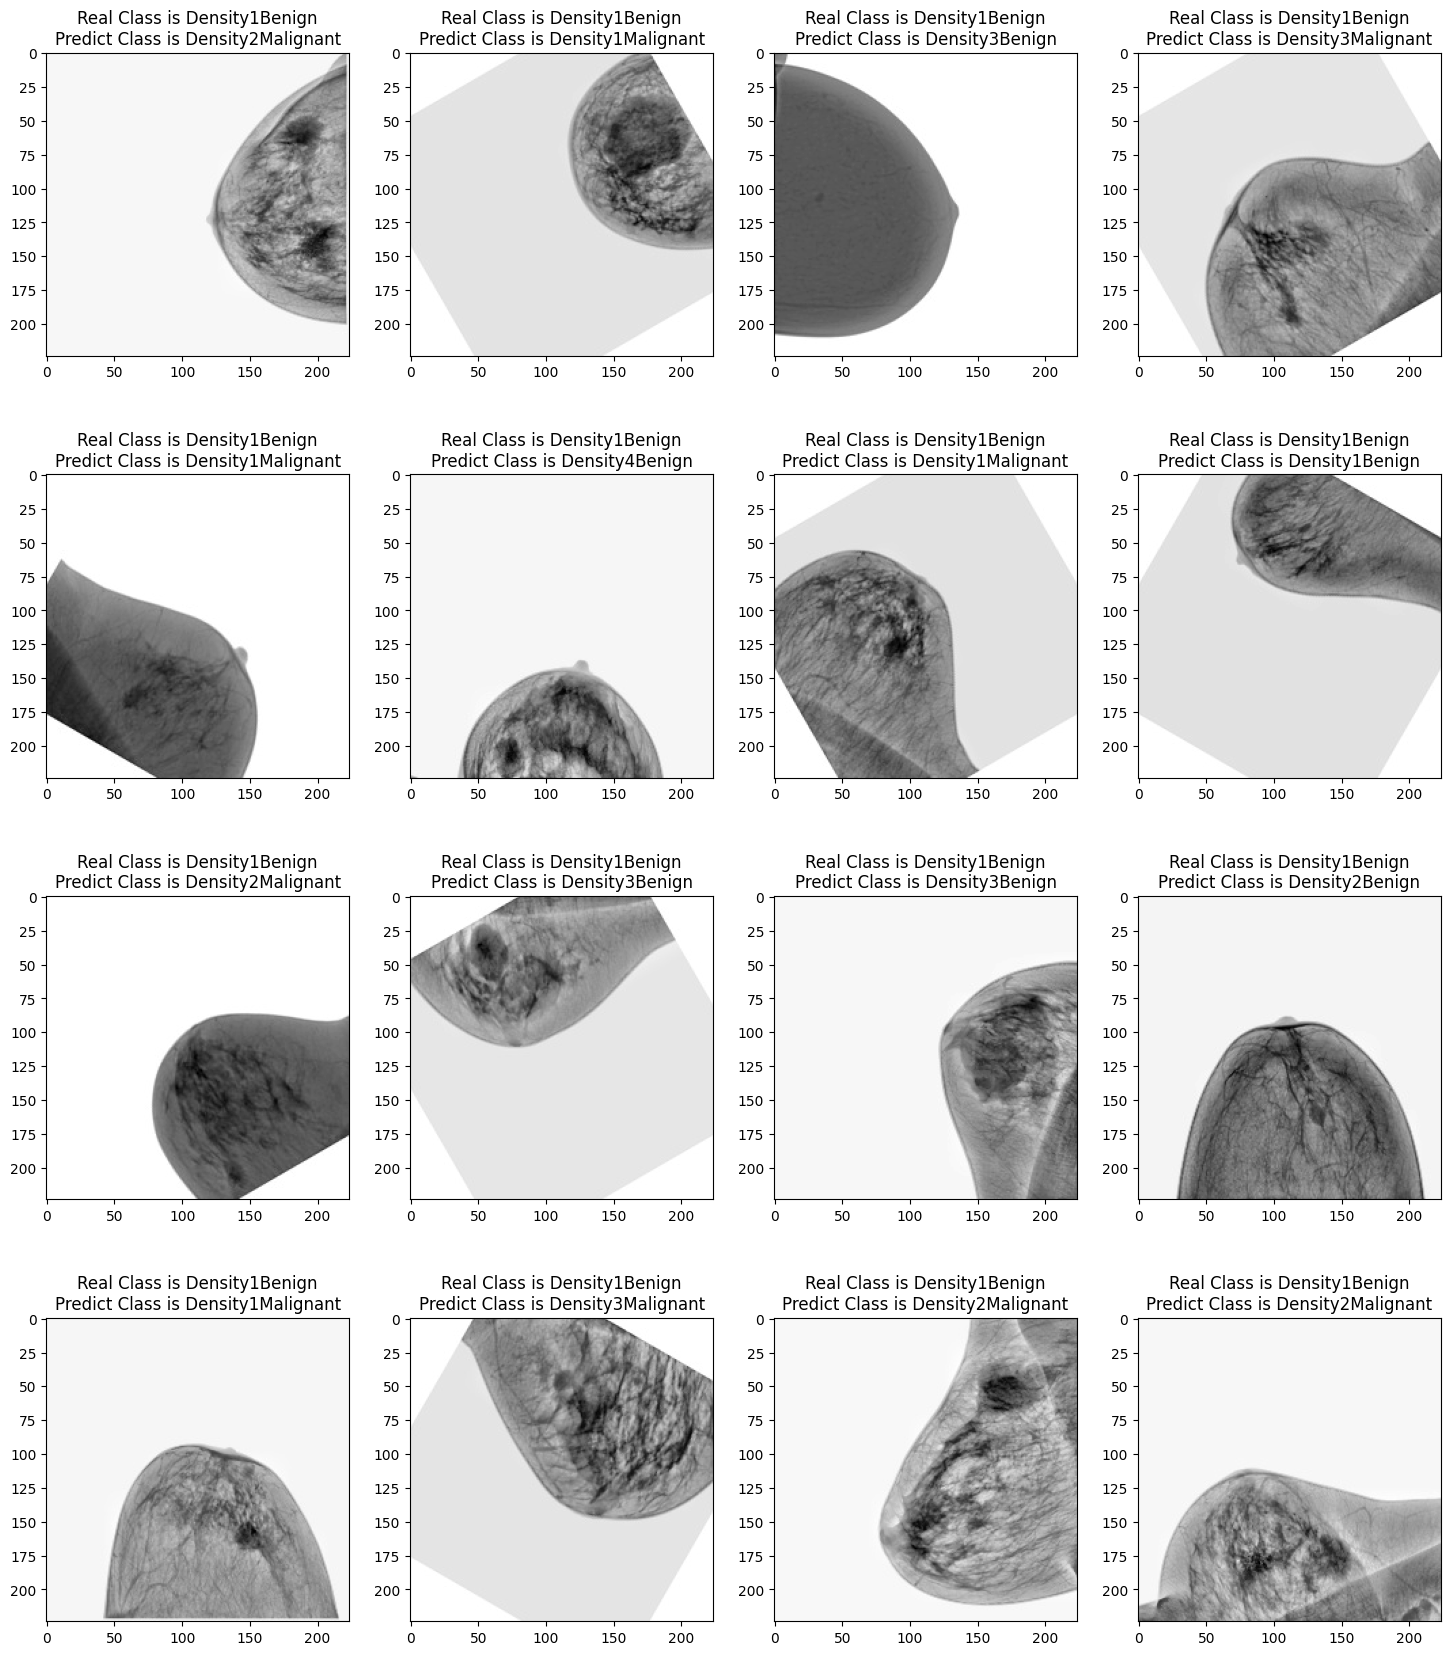

In [62]:
y_pred = model.predict(X_val)
X_test__ = X_val.reshape(X_val.shape[0], 224, 224)

fig, axis = plt.subplots(4, 4, figsize=(18, 21))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Class is {classes[y_val[i].argmax()]}\nPredict Class is {classes[y_pred[i].argmax()]}");

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


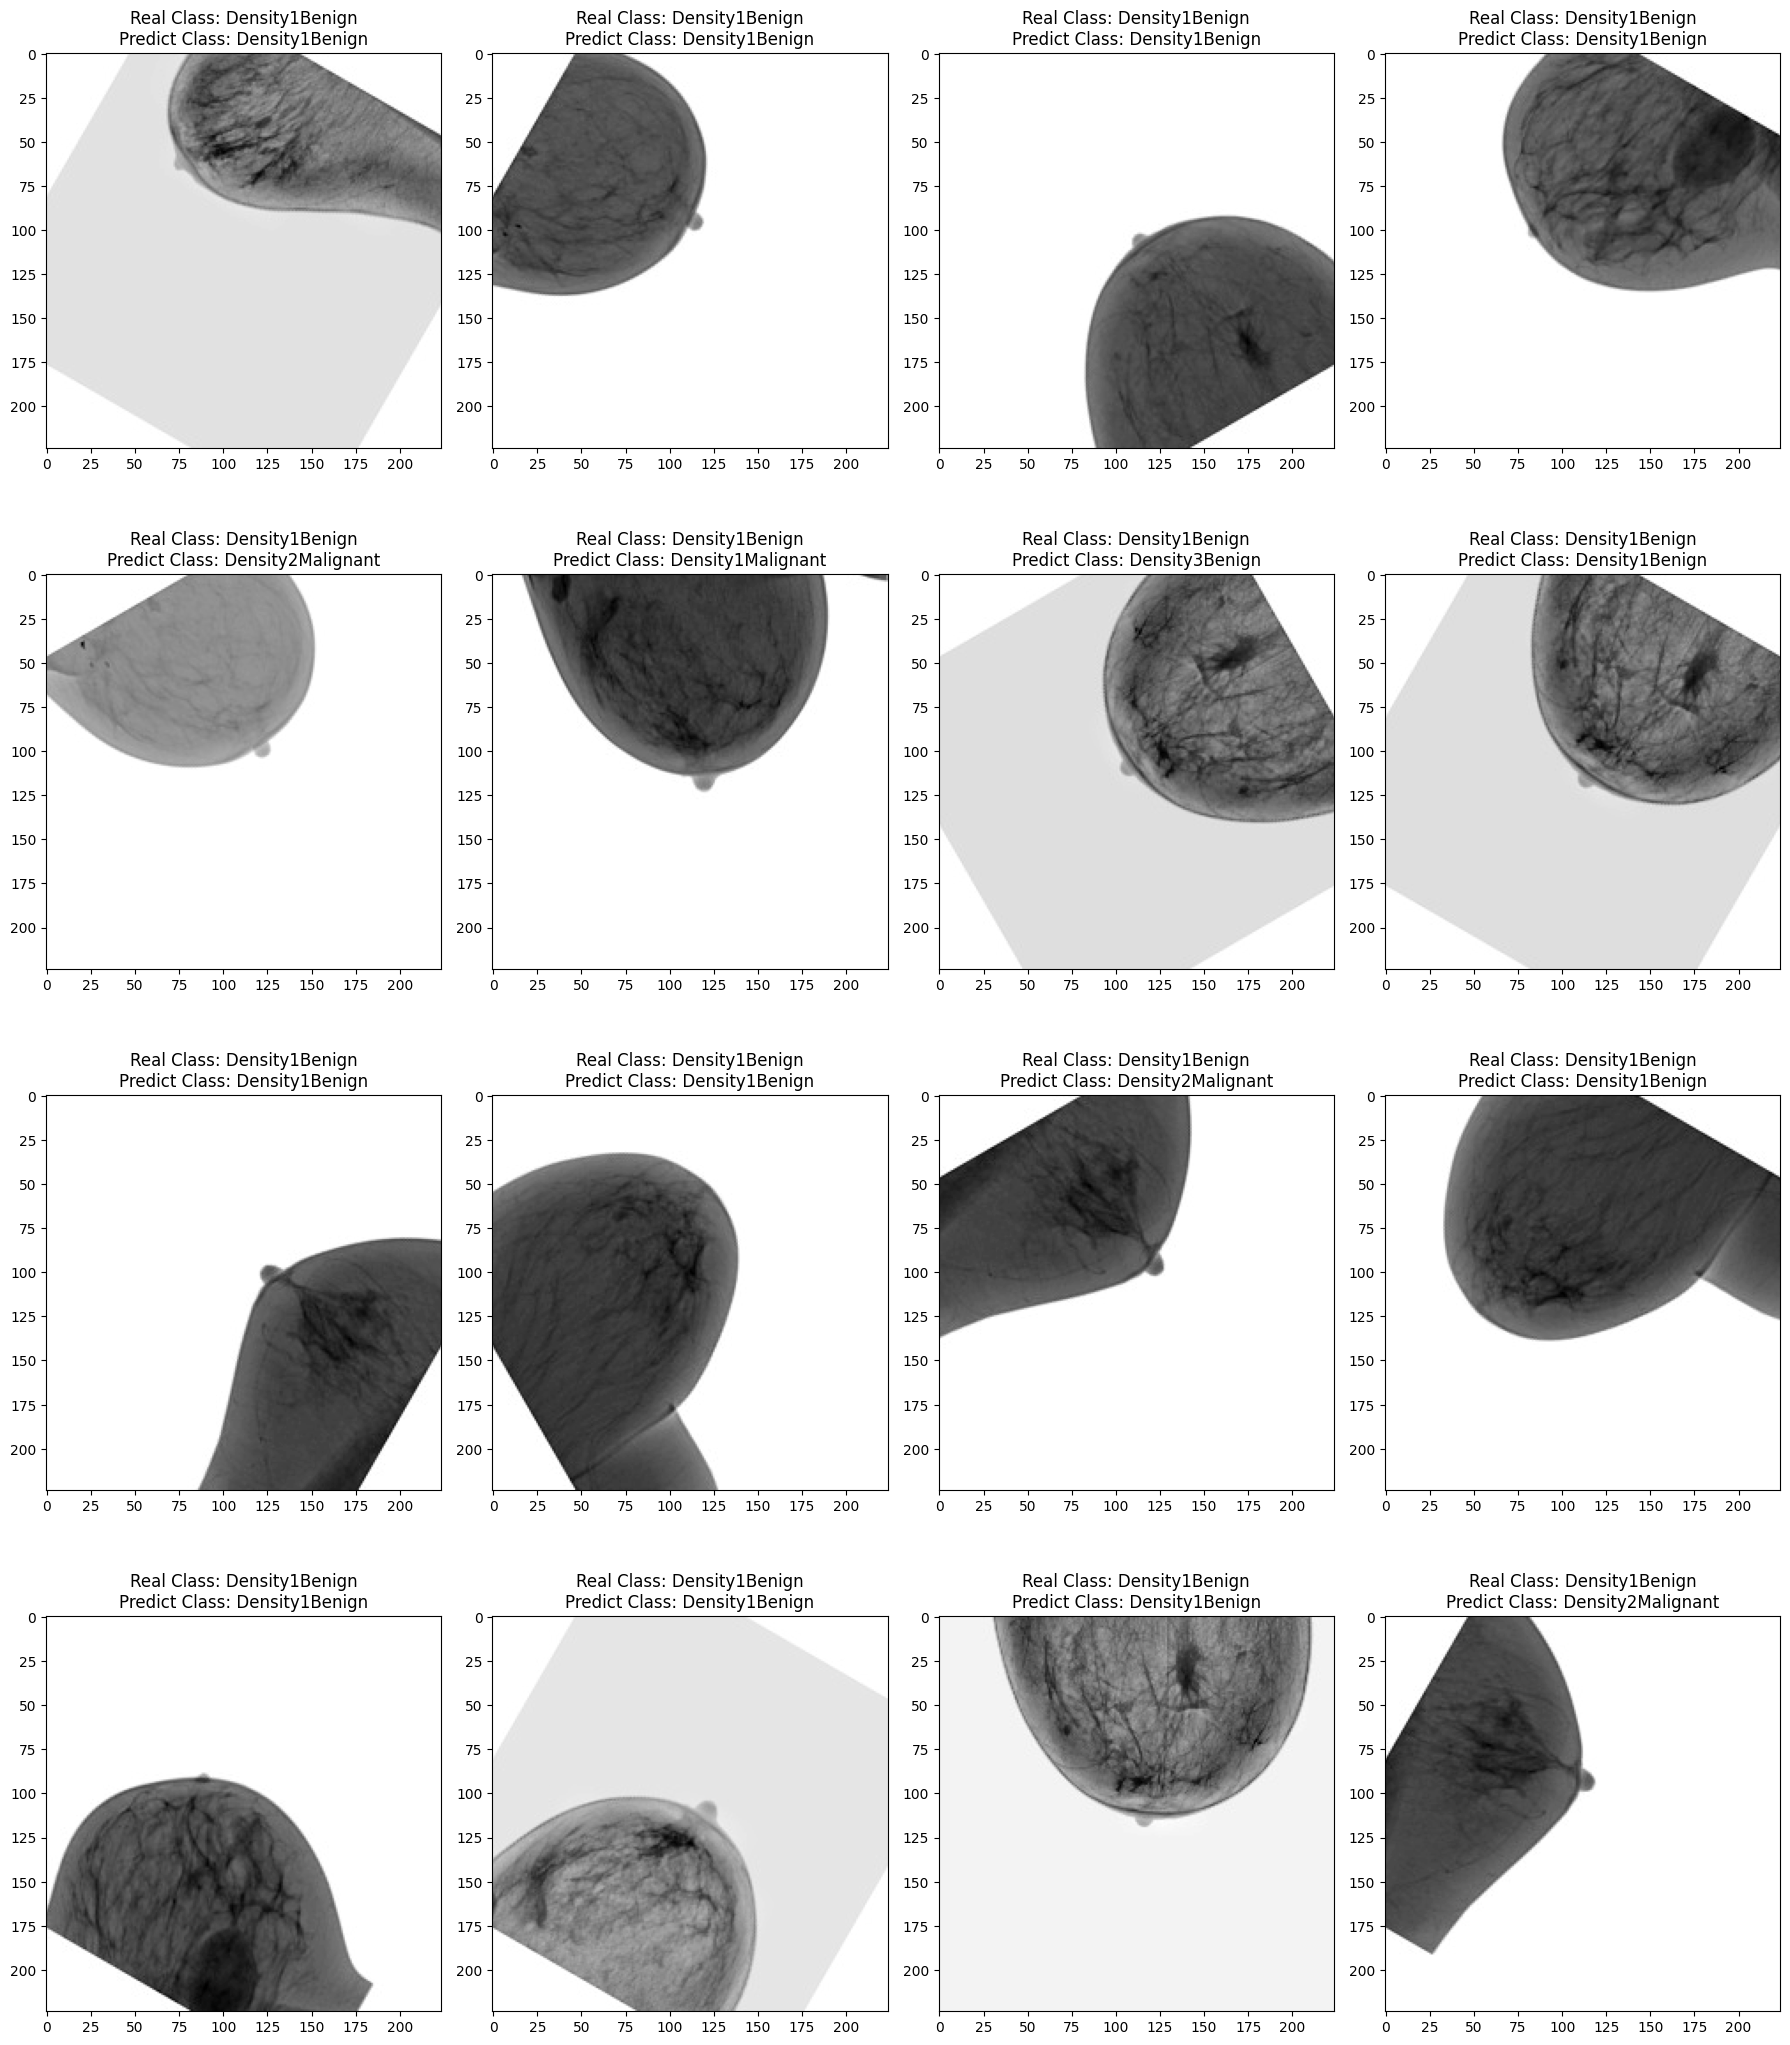


Статистика предсказаний для изображений класса Density1Benign:
Предсказано как Density1Benign: 99 раз (71.22%)
Предсказано как Density1Malignant: 17 раз (12.23%)
Предсказано как Density2Benign: 5 раз (3.60%)
Предсказано как Density2Malignant: 11 раз (7.91%)
Предсказано как Density3Benign: 7 раз (5.04%)


In [66]:
# Получаем предсказания
y_pred = model.predict(X_val)
X_test__ = X_val.reshape(X_val.shape[0], 224, 224)

# Находим индексы, где реальный класс - Density1Benign (класс 0)
density1_benign_indices = np.where(y_val == 0)[0]  # Убрали argmax, так как y_val уже содержит метки классов

# Создаем сетку для первых 16 изображений класса Density1Benign
fig, axis = plt.subplots(4, 4, figsize=(18, 21))
for i, ax in enumerate(axis.flat):
    if i < len(density1_benign_indices) and i < 16:
        idx = density1_benign_indices[i]
        ax.imshow(X_test__[idx], cmap='binary')
        ax.set(title=f"Real Class: Density1Benign\nPredict Class: {classes[y_pred[idx].argmax()]}")
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

# Выведем статистику предсказаний для класса Density1Benign
benign_predictions = y_pred[density1_benign_indices].argmax(axis=1)
unique_preds, counts = np.unique(benign_predictions, return_counts=True)
print("\nСтатистика предсказаний для изображений класса Density1Benign:")
for pred_class, count in zip(unique_preds, counts):
    percentage = (count / len(density1_benign_indices)) * 100
    print(f"Предсказано как {classes[pred_class]}: {count} раз ({percentage:.2f}%)")

# Pretrained model

In [2]:
import pandas as pd # Data analysis and manipultion tool
import numpy as np # Fundamental package for linear algebra and multidimensional arrays
from sklearn.model_selection import train_test_split # For splitting the data into train and validation set
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
#
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil
import glob
#
from fastai.vision.all import aug_transforms

from pathlib import Path
from fastai import *
from fastai.vision import *
import torch
from fastai.callback.hook import *
#
from imutils import build_montages
from imutils import paths
import argparse
import random
import cv2
import warnings
warnings.filterwarnings('ignore')

In [3]:
imagePaths = list(paths.list_images("/kaggle/input/inbreast/mamog/train"))
random.shuffle(imagePaths)
imagePaths = imagePaths[:21]

In [4]:
imagePaths[0]

'/kaggle/input/inbreast/mamog/train/Image_3501.jpg'

In [5]:
# initialize the list of images
images = []
# loop over the list of image paths
for imagePath in imagePaths:
	# load the image and update the list of images
	image = cv2.imread(imagePath)
	images.append(image)
# construct the montages for the images
montages = build_montages(images, (224, 224), (7, 3))

In [6]:
img = cv2.imread(imagePaths[0])
img.shape

(224, 224, 3)

In [28]:
print(dls.vocab)  # Список классов
print(len(dls.vocab))  # Количество классов


['Density1Benign', 'Density1Malignant', 'Density2Benign', 'Density2Malignant', 'Density3Benign', 'Density3Malignant', 'Density4Benign', 'Density4Malignant']
8


In [38]:
import gc
gc.collect()
torch.cuda.empty_cache()


In [13]:
learn = cnn_learner(dls, models.densenet121, metrics=[error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 141MB/s] 


In [14]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.841190,1.268096,0.411713,0.588287,01:10
1,0.919499,0.350062,0.122378,0.877622,01:07
2,0.374539,0.138910,0.045455,0.954545,01:07
3,0.204353,0.034625,0.003497,0.996503,01:09
4,0.197507,0.024609,0.001748,0.998252,01:07


In [16]:
from fastai.metrics import MultiLabelFbeta


ImportError: cannot import name 'MultiLabelFbeta' from 'fastai.metrics' (/usr/local/lib/python3.10/dist-packages/fastai/metrics.py)

In [18]:
F1 =  FBetaMulti  (beta=8, average="macro")

In [20]:
learn2 = learn = cnn_learner(dls, models.resnet152, metrics=[error_rate, accuracy,F1])

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:04<00:00, 53.4MB/s] 
